<a href="https://colab.research.google.com/github/lponcec94/PolyWorks/blob/main/semana_4/Ejemplo_InternetTraffic_Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Objetivo:

Implementar un modelo ARIMA en una serie de tiempo sobre cantidad de tráfico (bits) en un servidor de internet. 

Temas a revisar:

1. Tendencia y estacionareidad  
2. Graficar autocorrelación 
3. Test Dickey-Fuller 
4. Predecir el compartamiento de nuestros datos a futuro.

### Lectura y exploración

In [2]:
import warnings
import itertools

import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
from pylab import rcParams

import statsmodels.api as sm
from statsmodels.graphics import tsaplots
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX 

warnings.filterwarnings("ignore")


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
a5m = pd.read_csv('https://raw.githubusercontent.com/lponcec94/PolyWorks/main/semana_4/data/A5M.csv', names=['bits'])
a1h = pd.read_csv('https://raw.githubusercontent.com/lponcec94/PolyWorks/main/semana_4/data/A1H.csv', names=['bits'])
a1d = pd.read_csv('https://raw.githubusercontent.com/lponcec94/PolyWorks/main/semana_4/data/A1D.csv', names=['bits'])

start = 2005/06/07 6:57 AM

end = 2005/07/29 11:17 AM

In [4]:
a5m.head()

,bits
0,106868373810
1,111306467130
2,116324091090
3,116290646130
4,137476277430


In [5]:
a5m.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14772 entries, 0 to 14771
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   bits    14772 non-null  int64
dtypes: int64(1)
memory usage: 115.5 KB


#### Visualización de comportamiento

Recordemos que los tres datasets son del mismo periodo de tiempo, lo que se modifica es la frecuencia de la medición.

In [6]:
rcParams['figure.figsize'] = 10, 5

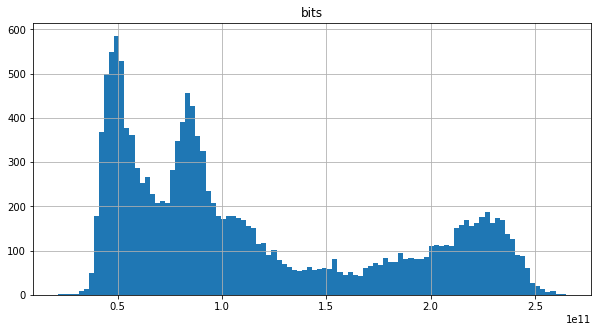

In [7]:
# Periodo de medición cada 5 minutos. 
a5m.hist(bins=100);

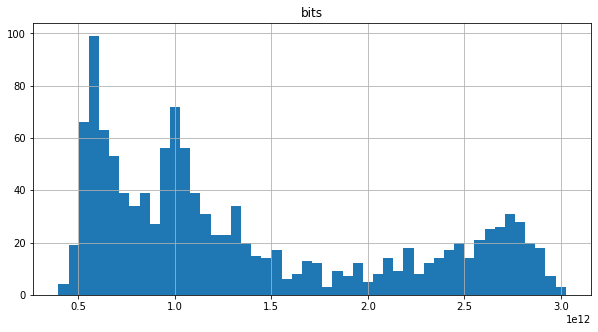

In [8]:
# Frecuencia cada hora
a1h.hist(bins=50);

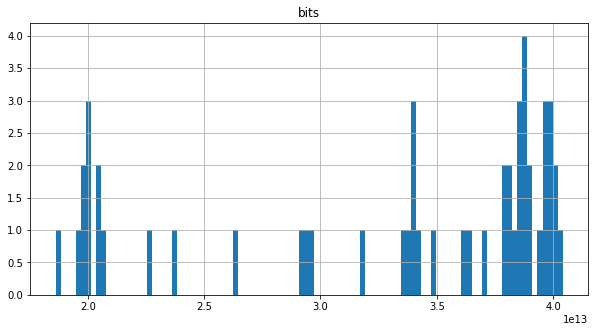

In [9]:
# Frecuencia cada día 
a1d.hist(bins=100);

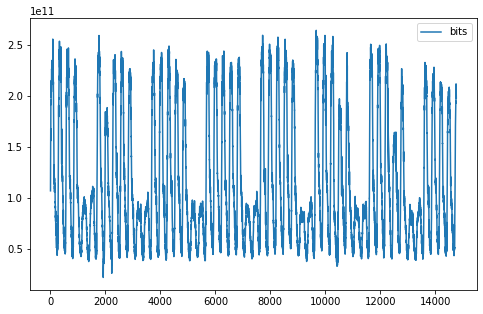

In [10]:
rcParams['figure.figsize'] = 8, 5

a5m.plot();

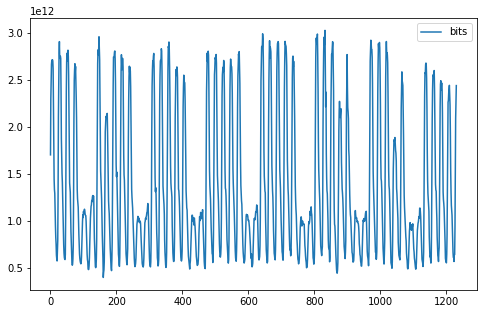

In [11]:
a1h.plot();

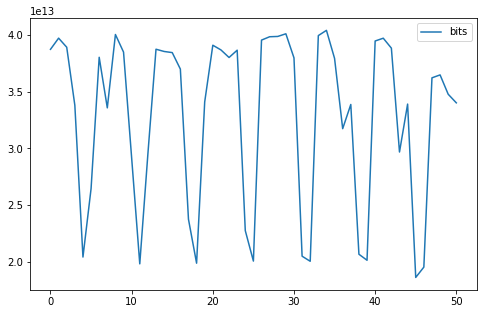

In [12]:
a1d.plot();

#### Colocando la fecha con el periodo de duración correspondiente

In [13]:
date_5m = pd.date_range(start='06/07/2005 06:57:00', 
              end='07/29/2005 11:17:00', 
              freq='5min')
date_1h = pd.date_range(start='06/07/2005 06:57:00', 
              end='07/29/2005 11:17:00', 
              freq='H')
date_1d = pd.date_range(start='06/07/2005', 
              end='07/29/2005', 
              freq='D')

In [14]:
len(date_5m), a5m.shape

(15029, (14772, 1))

In [15]:
len(date_1h), a1h.shape

(1253, (1231, 1))

In [16]:
len(date_1d), a1d.shape

(53, (51, 1))

In [17]:
date_ser_5m = pd.Series(date_5m, name='date')
date_ser_1h = pd.Series(date_1h, name='date')
date_ser_1d = pd.Series(date_1d, name='date')

In [18]:
date_ser_5m[:10]

0   2005-06-07 06:57:00
1   2005-06-07 07:02:00
2   2005-06-07 07:07:00
3   2005-06-07 07:12:00
4   2005-06-07 07:17:00
5   2005-06-07 07:22:00
6   2005-06-07 07:27:00
7   2005-06-07 07:32:00
8   2005-06-07 07:37:00
9   2005-06-07 07:42:00
Name: date, dtype: datetime64[ns]

In [19]:
df_a5m = pd.concat([a5m, date_ser_5m], axis=1)
df_a1h = pd.concat([a1h, date_ser_1h], axis=1)
df_a1d = pd.concat([a1d, date_ser_1d], axis=1)

In [20]:
df_a5m.head()

,bits,date
0,1.068684e+11,2005-06-07 06:57:00
1,1.113065e+11,2005-06-07 07:02:00
2,1.163241e+11,2005-06-07 07:07:00
3,1.162906e+11,2005-06-07 07:12:00
4,1.374763e+11,2005-06-07 07:17:00


In [21]:
df_a5m.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15029 entries, 0 to 15028
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   bits    14772 non-null  float64       
 1   date    15029 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1)
memory usage: 235.0 KB


Eliminamos los valores nulos para cada una de las series. Los valores nulos son de periodos en los que hubo problemas de medición. 

In [22]:
df_a5m.dropna(inplace=True)
df_a1h.dropna(inplace=True)
df_a1d.dropna(inplace=True)

In [23]:
df_a5m.shape, df_a1h.shape, df_a1d.shape

((14772, 2), (1231, 2), (51, 2))

Colocamos la fecha como índice para poder manipular nuestros datos.

In [24]:
df_a5m.set_index('date', inplace=True, drop=True)
df_a1h.set_index('date', inplace=True, drop=True)
df_a1d.set_index('date', inplace=True, drop=True)

In [25]:
df_a5m.head()

,bits
date,
2005-06-07 06:57:00,1.068684e+11
2005-06-07 07:02:00,1.113065e+11
2005-06-07 07:07:00,1.163241e+11
2005-06-07 07:12:00,1.162906e+11
2005-06-07 07:17:00,1.374763e+11


In [26]:
df_a5m.index

DatetimeIndex(['2005-06-07 06:57:00', '2005-06-07 07:02:00',
               '2005-06-07 07:07:00', '2005-06-07 07:12:00',
               '2005-06-07 07:17:00', '2005-06-07 07:22:00',
               '2005-06-07 07:27:00', '2005-06-07 07:32:00',
               '2005-06-07 07:37:00', '2005-06-07 07:42:00',
               ...
               '2005-07-28 13:07:00', '2005-07-28 13:12:00',
               '2005-07-28 13:17:00', '2005-07-28 13:22:00',
               '2005-07-28 13:27:00', '2005-07-28 13:32:00',
               '2005-07-28 13:37:00', '2005-07-28 13:42:00',
               '2005-07-28 13:47:00', '2005-07-28 13:52:00'],
              dtype='datetime64[ns]', name='date', length=14772, freq=None)

In [27]:
df_a1h.head()

,bits
date,
2005-06-07 06:57:00,1.701558e+12
2005-06-07 07:57:00,2.293685e+12
2005-06-07 08:57:00,2.476021e+12
2005-06-07 09:57:00,2.663910e+12
2005-06-07 10:57:00,2.707438e+12


In [28]:
df_a1d.head()

,bits
date,
2005-06-07,3.874141e+13
2005-06-08,3.972759e+13
2005-06-09,3.892572e+13
2005-06-10,3.380388e+13
2005-06-11,2.041519e+13


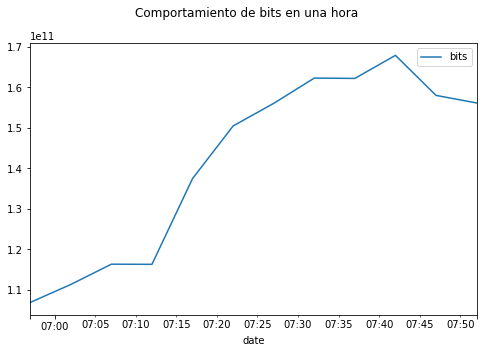

In [29]:
df_a5m.iloc[:12].plot();
plt.suptitle('Comportamiento de bits en una hora');

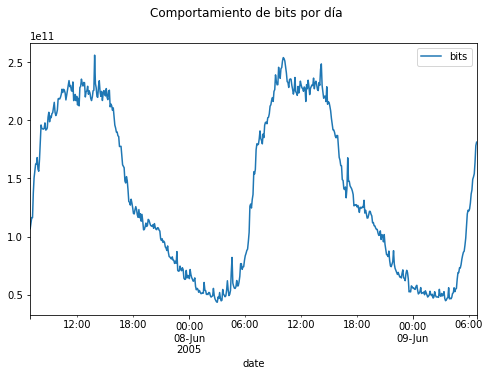

In [30]:
df_a5m.iloc[:576].plot();
plt.suptitle('Comportamiento de bits por día');

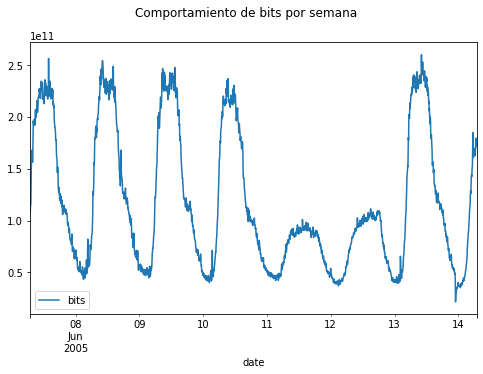

In [31]:
df_a5m.iloc[:2016].plot();
plt.suptitle('Comportamiento de bits por semana');

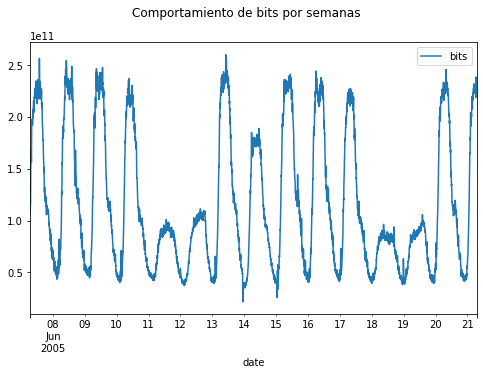

In [32]:
df_a5m.iloc[:4032].plot();
plt.suptitle('Comportamiento de bits por semanas');

### Revisando la tendencía y la estacionareidad

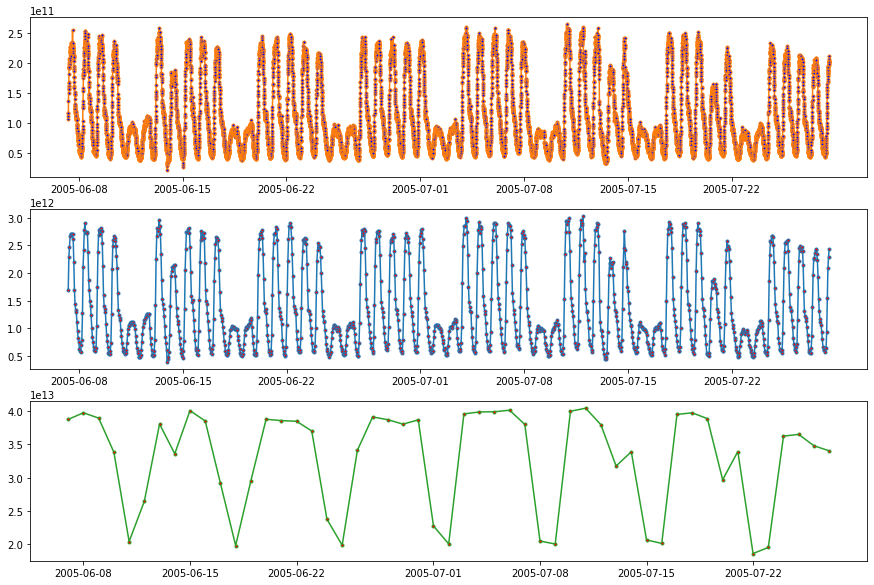

<Figure size 576x360 with 0 Axes>

In [33]:
fig, ax = plt.subplots(3, figsize=(15, 10))
plt.figure(facecolor='w')
ax[0].plot(df_a5m, marker='o', 
            markersize=3,
            markerfacecolor='blue', 
            color='tab:orange')
ax[1].plot(df_a1h, marker='o', 
            markersize=3,
            markerfacecolor='red', 
            color='tab:blue')
ax[2].plot(df_a1d, marker='o', 
            markersize=3,
            markerfacecolor='red', 
            color='tab:green');

### AdFuller Test

In [34]:
def viewing_stationarity(df, window=5):
  rolmean = df.rolling(window=window).mean()
  rolstd = df.rolling(window=window).std()

  fig = plt.figure(figsize=(10, 5))
  time_series = plt.plot(df, color='blue', label='original')
  mean = plt.plot(rolmean, color='red', label='media movil')
  std = plt.plot(rolstd, color='green', label='desviación estandar movil')
  plt.legend(loc='best')
  plt.show();

In [35]:
class Stationarity:
  def __init__(self, significance=0.05):
    self.significance_level = significance
    self.pvalue = None
    self.is_stationarity = None 
  
  def ADF(self, values):
    result = adfuller(values, autolag='AIC')

    format_results = pd.Series(result[:4], 
                               index=['Statistic', 'P-value',
                                      'Num of Lags', 'Observations'])
    for k, v in result[4].items():
      format_results[f'Crical Value {k}'] = v

    
    return format_results


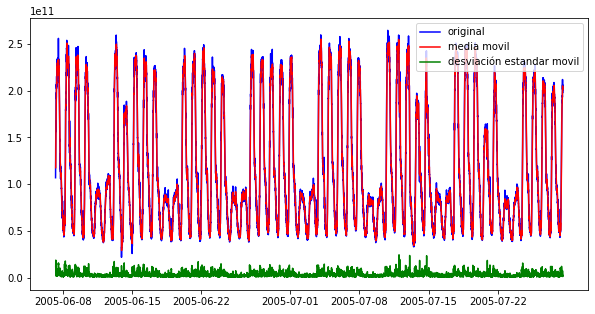

In [36]:
viewing_stationarity(df_a5m, window=5)

H0 = Nuestros datos no son estacionarios

H1 = Nuestros datos sí son estacionarios

In [37]:
adf_test = Stationarity()
adf_test.ADF(df_a5m['bits'].values).round(5)

Statistic             -12.94832
P-value                 0.00000
Num of Lags            41.00000
Observations        14730.00000
Crical Value 1%        -3.43079
Crical Value 5%        -2.86174
Crical Value 10%       -2.56687
dtype: float64

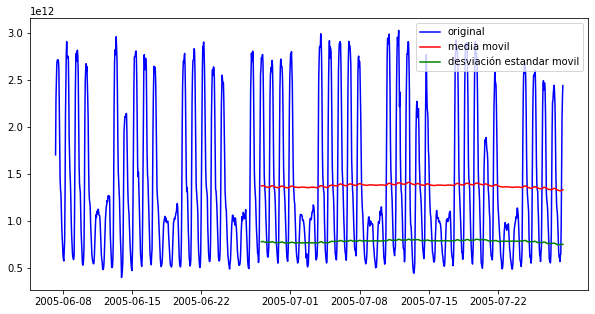

Statistic             -6.021008
P-value                0.000000
Num of Lags           23.000000
Observations        1207.000000
Crical Value 1%       -3.435779
Crical Value 5%       -2.863938
Crical Value 10%      -2.568046
dtype: float64

In [38]:
viewing_stationarity(df_a1h, window=500)
adf_test = Stationarity()
adf_test.ADF(df_a1h['bits'].values).round(6)

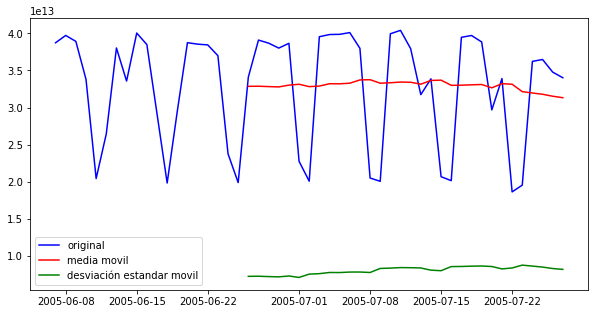

Statistic           -1.232170
P-value              0.659606
Num of Lags          6.000000
Observations        44.000000
Crical Value 1%     -3.588573
Crical Value 5%     -2.929886
Crical Value 10%    -2.603185
dtype: float64

In [39]:
viewing_stationarity(df_a1d, window=20)
adf_test = Stationarity()
adf_test.ADF(df_a1d['bits'].values).round(6)

En este caso se intentó hacer un tratamiento del periodo de medición de cada cinco minutos, debido a que la función para descomponer la tendencia requiere en algunos casos colocar el número correcto de la frequencia. 

In [40]:
test = df_a5m.asfreq('min')

In [41]:
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 73856 entries, 2005-06-07 06:57:00 to 2005-07-28 13:52:00
Freq: T
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   bits    14772 non-null  float64
dtypes: float64(1)
memory usage: 1.1 MB


In [42]:
test.dropna(inplace=True)

In [43]:
test.head()

,bits
date,
2005-06-07 06:57:00,1.068684e+11
2005-06-07 07:02:00,1.113065e+11
2005-06-07 07:07:00,1.163241e+11
2005-06-07 07:12:00,1.162906e+11
2005-06-07 07:17:00,1.374763e+11


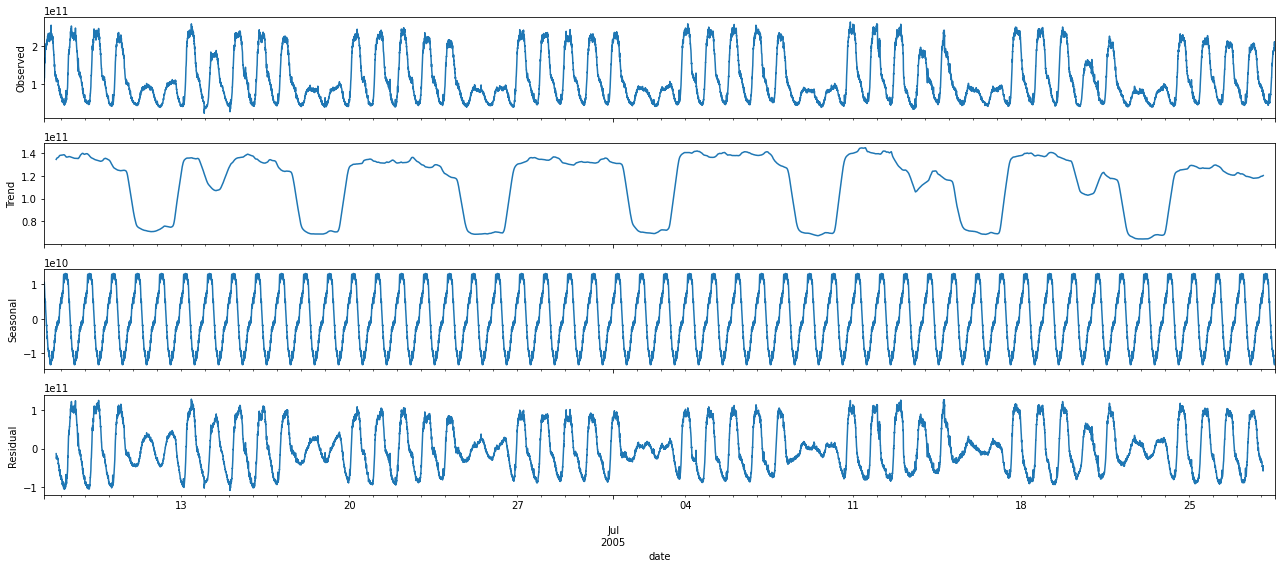

In [44]:
rcParams['figure.figsize'] = 18, 8

decomposition = sm.tsa.seasonal_decompose(test, model='additive', freq=((24*60)//5))
fig = decomposition.plot()
plt.show()

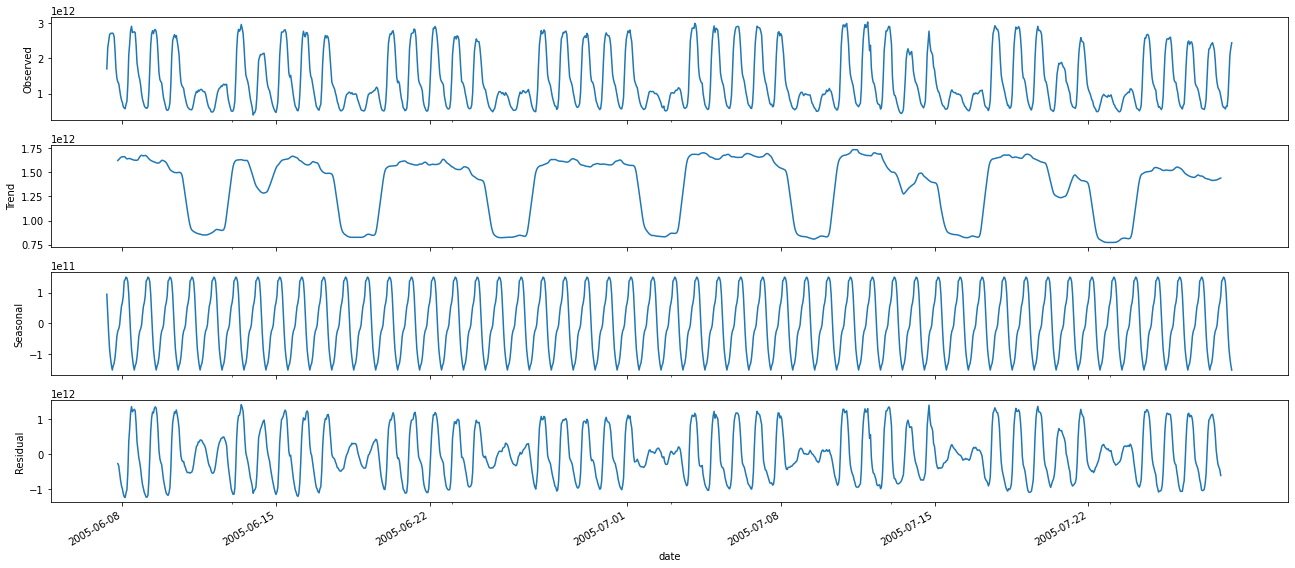

In [45]:
rcParams['figure.figsize'] = 18, 8

decomposition = sm.tsa.seasonal_decompose(df_a1h, model='additive')
fig = decomposition.plot()
plt.show()

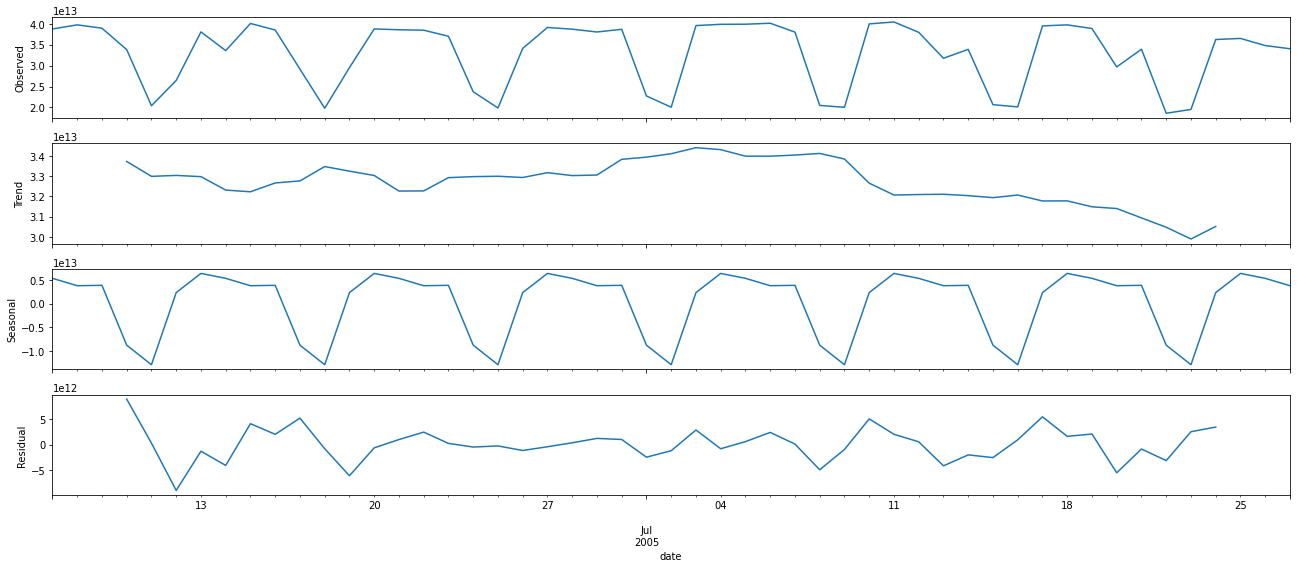

In [46]:
rcParams['figure.figsize'] = 18, 8

decomposition = sm.tsa.seasonal_decompose(df_a1d['bits'], model='additive')
fig = decomposition.plot()
plt.show()

### Gráficos de autocorrelación

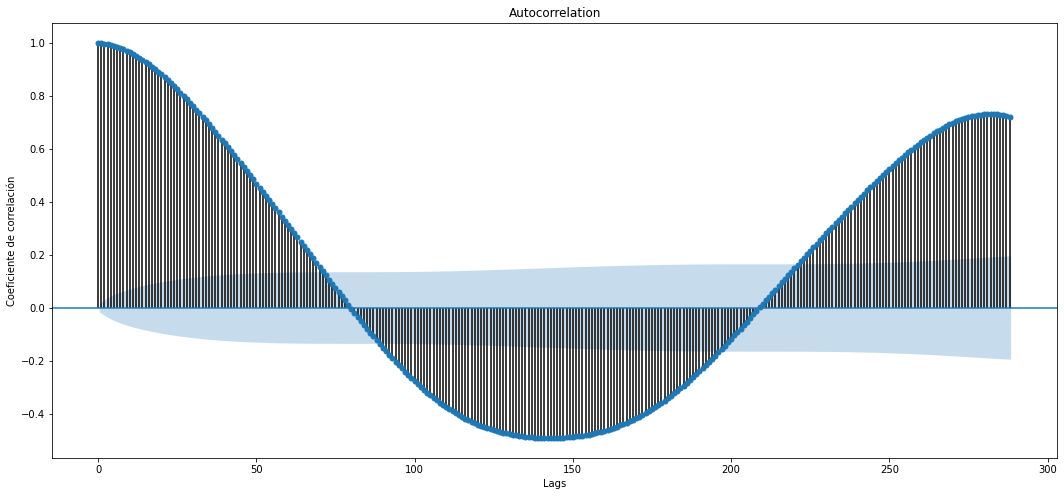

In [47]:
tsaplots.plot_acf(df_a5m['bits'].values.squeeze(), lags=288)
plt.xlabel('Lags')
plt.ylabel('Coeficiente de correlación')
plt.show()

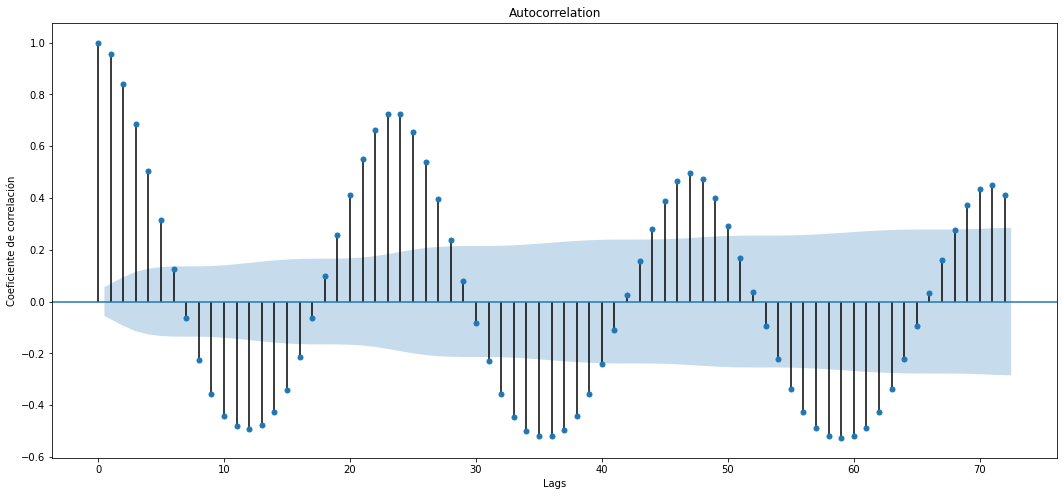

In [48]:
tsaplots.plot_acf(df_a1h['bits'].values.squeeze(), lags=72)
plt.xlabel('Lags')
plt.ylabel('Coeficiente de correlación')
plt.show()

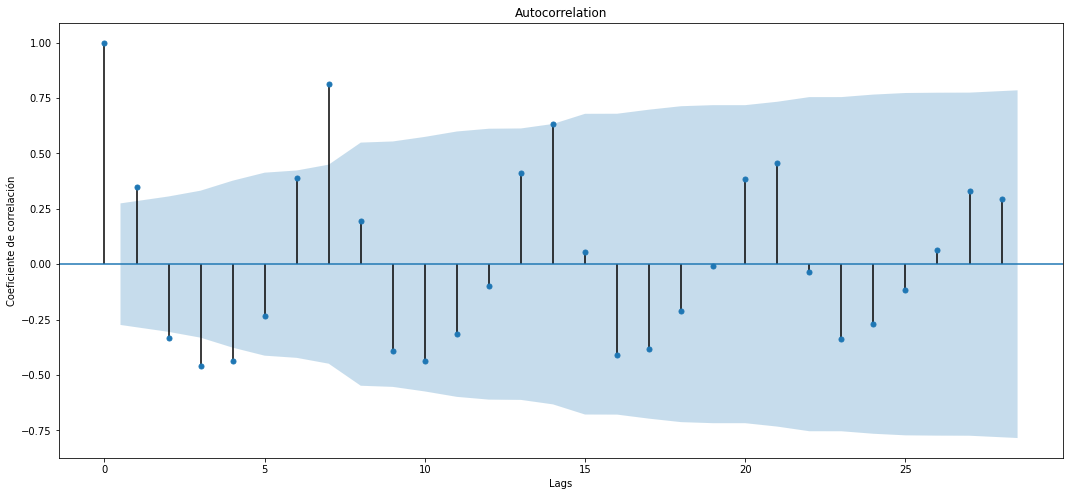

In [49]:
tsaplots.plot_acf(df_a1d['bits'].values.squeeze(), lags=28)
plt.xlabel('Lags')
plt.ylabel('Coeficiente de correlación')
plt.show()

### Diferenciación 

**La serie con frecuencia de 1 día no es estacionaria, por lo tanto requiere que la transformemos para poder aplicar método autoregresivos.** 

In [50]:
df_a1d.head()

,bits
date,
2005-06-07,3.874141e+13
2005-06-08,3.972759e+13
2005-06-09,3.892572e+13
2005-06-10,3.380388e+13
2005-06-11,2.041519e+13


In [51]:
df_a1d['difference_1'] = df_a1d['bits'] - df_a1d['bits'].shift(1)

In [52]:
df_a1d.head()

,bits,difference_1
date,,
2005-06-07,3.874141e+13,NaN
2005-06-08,3.972759e+13,9.861763e+11
2005-06-09,3.892572e+13,-8.018729e+11
2005-06-10,3.380388e+13,-5.121836e+12
2005-06-11,2.041519e+13,-1.338869e+13


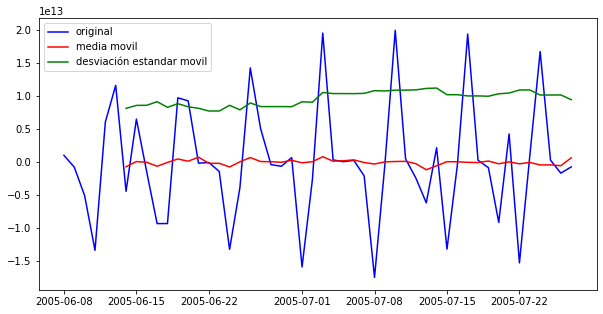

Statistic          -20.240697
P-value              0.000000
Num of Lags          5.000000
Observations        44.000000
Crical Value 1%     -3.588573
Crical Value 5%     -2.929886
Crical Value 10%    -2.603185
dtype: float64

In [53]:
viewing_stationarity(df_a1d['difference_1'].dropna(), window=7)
adf_test = Stationarity()
adf_test.ADF(df_a1d['difference_1'].dropna().values).round(6)

In [54]:
df_a1d['difference_2'] = df_a1d['difference_1'] - df_a1d['difference_1'].shift(1)

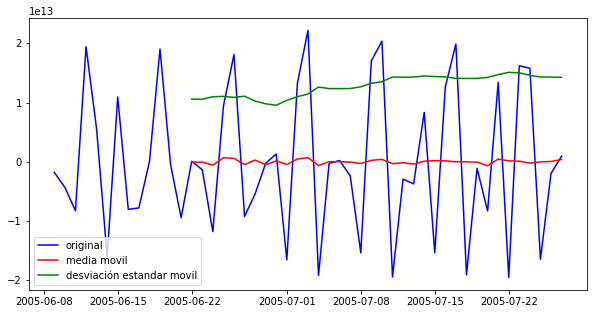

Statistic           -3.976595
P-value              0.001538
Num of Lags          9.000000
Observations        39.000000
Crical Value 1%     -3.610400
Crical Value 5%     -2.939109
Crical Value 10%    -2.608063
dtype: float64

In [55]:
viewing_stationarity(df_a1d['difference_2'].dropna(), window=14)
adf_test = Stationarity()
adf_test.ADF(df_a1d['difference_2'].dropna().values).round(6)

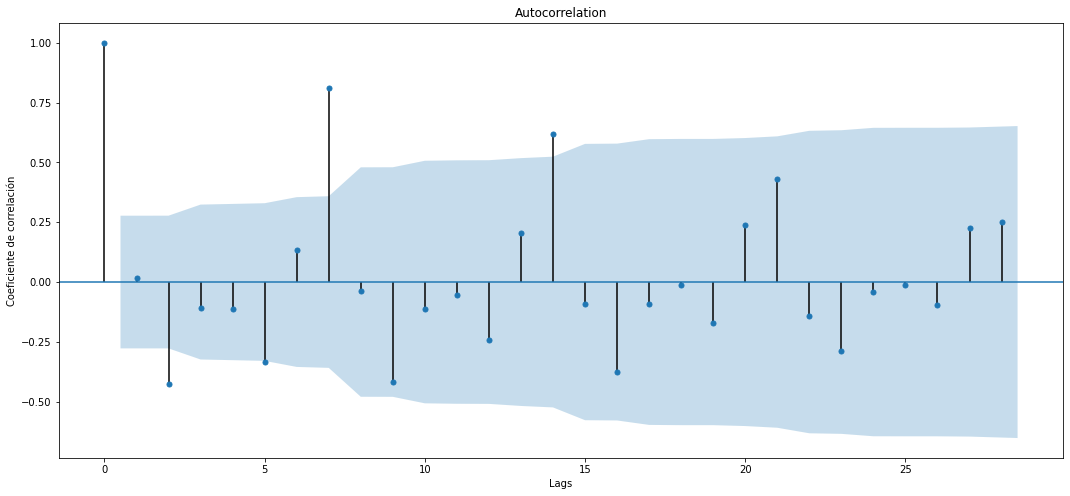

In [56]:
tsaplots.plot_acf(df_a1d['difference_1'].dropna().values, lags=28)
plt.xlabel('Lags')
plt.ylabel('Coeficiente de correlación')
plt.show()

### ARIMA

In [57]:
# Definimos los rangos en los que vamos a probar P,D,Q
p = d = q = range(0, 6)
pdq = list(itertools.product(p, d, q))

In [59]:
pdq[-1]

(5, 5, 5)

In [ ]:
model = list()
aic = list()

for param in pdq:
  try:
      mod = SARIMAX(df_a5m,
                    order=param,
                    enforce_stationarity=False)
      results = mod.fit()
      model.append(param)
      aic.append(results.aic)
      print('ARIMA{}- AIC:{}'.format(param, results.aic))
  except:
    print('')
    print('Error')
    continue


ARIMA(0, 0, 0)- AIC:798249.6757264652
ARIMA(0, 0, 1)- AIC:787282.9209187159
ARIMA(0, 0, 2)- AIC:784591.7245646395
ARIMA(0, 0, 3)- AIC:783813.7291022287
ARIMA(0, 0, 4)- AIC:783499.7096436128
ARIMA(0, 0, 5)- AIC:783331.4627338971
ARIMA(0, 1, 0)- AIC:696982.1234432589
ARIMA(0, 1, 1)- AIC:696930.1556071895
ARIMA(0, 1, 2)- AIC:696885.025832181
ARIMA(0, 1, 3)- AIC:696681.6017249734
ARIMA(0, 1, 4)- AIC:696519.3009083553
ARIMA(0, 1, 5)- AIC:696204.213157976
ARIMA(0, 2, 0)- AIC:707478.5588706338
ARIMA(0, 2, 1)- AIC:697132.7013608941
ARIMA(0, 2, 2)- AIC:696413.7859121431
ARIMA(0, 2, 3)- AIC:695789.6822427603
ARIMA(0, 2, 4)- AIC:695573.4718273964
ARIMA(0, 2, 5)- AIC:695392.011403101
ARIMA(0, 3, 0)- AIC:723778.1068378577
ARIMA(0, 3, 1)- AIC:708613.6637759653
ARIMA(0, 3, 2)- AIC:701268.1151645423
ARIMA(0, 3, 3)- AIC:700096.3584056742
ARIMA(0, 3, 4)- AIC:698947.890464184
ARIMA(0, 3, 5)- AIC:698405.492669971
ARIMA(0, 4, 0)- AIC:741423.4657856395
ARIMA(0, 4, 1)- AIC:724389.297994025
ARIMA(0, 4, 2)- AI

In [ ]:
df_models_a5m = pd.DataFrame(zip(model, aic), columns=['model', 'aic'])
df_models_a5m.sort_values('aic').head()
# ARIMA(4, 1, 5)- AIC:694891.6259100339

,model,aic
155,"(4, 1, 5)",694891.625910
191,"(5, 1, 5)",694897.699083
119,"(3, 1, 5)",694956.914443
190,"(5, 1, 4)",694991.252844
83,"(2, 1, 5)",694993.620285


In [ ]:
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 24) for x in list(itertools.product(p, d, q))]

In [ ]:
model = list()
aic = list()

for param in pdq:
  for param_seasonal in seasonal_pdq:
      try:
          mod = SARIMAX(df_a1h,
                        order=param,
                        seasonal_order=param_seasonal,
                        enforce_stationarity=False)
          results = mod.fit()
          model.append(param)
          aic.append(results.aic)
          print('SARIMAX{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
      except:
        print('')
        print('Error')
        continue


ARIMA(0, 0, 0)x(0, 0, 0, 24) - AIC:72582.58433660134
ARIMA(0, 0, 0)x(0, 0, 1, 24) - AIC:70370.24888277511
ARIMA(0, 0, 0)x(0, 0, 2, 24) - AIC:68843.24280709568
ARIMA(0, 0, 0)x(0, 1, 0, 24) - AIC:68673.42366830831
ARIMA(0, 0, 0)x(0, 1, 1, 24) - AIC:67312.97576981704
ARIMA(0, 0, 0)x(0, 1, 2, 24) - AIC:65715.94173780143
ARIMA(0, 0, 0)x(0, 2, 0, 24) - AIC:68211.35163501045
ARIMA(0, 0, 0)x(0, 2, 1, 24) - AIC:66288.08597706225
ARIMA(0, 0, 0)x(0, 2, 2, 24) - AIC:64867.5959075761
ARIMA(0, 0, 0)x(1, 0, 0, 24) - AIC:68689.41838123114
ARIMA(0, 0, 0)x(1, 0, 1, 24) - AIC:68635.19122612996
ARIMA(0, 0, 0)x(1, 0, 2, 24) - AIC:67103.74966113188
ARIMA(0, 0, 0)x(1, 1, 0, 24) - AIC:67382.71636973278
ARIMA(0, 0, 0)x(1, 1, 1, 24) - AIC:67187.2950108507
ARIMA(0, 0, 0)x(1, 1, 2, 24) - AIC:65714.98449940016
ARIMA(0, 0, 0)x(1, 2, 0, 24) - AIC:66753.4961466762
ARIMA(0, 0, 0)x(1, 2, 1, 24) - AIC:66221.97117019109
ARIMA(0, 0, 0)x(1, 2, 2, 24) - AIC:64769.866551503874
ARIMA(0, 0, 0)x(2, 0, 0, 24) - AIC:67344.1759866

In [ ]:
df_models_a1h = pd.DataFrame(zip(model, aic), columns=['model', 'aic'])
df_models_a1h.sort_values('aic').head()
# ARIMA(0, 1, 2)x(2, 2, 2, 24) - AIC:61537.27001653737

In [110]:
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [113]:
df_a1d['difference_1'].head()

date
2005-06-07             NaN
2005-06-08    9.861763e+11
2005-06-09   -8.018729e+11
2005-06-10   -5.121836e+12
2005-06-11   -1.338869e+13
Name: difference_1, dtype: float64

In [116]:
model = list()
aic = list()

for param in pdq:
  for param_seasonal in seasonal_pdq:
      try:
          mod = SARIMAX(df_a1d['difference_1'].dropna(),
                        order=param,
                        seasonal_order=param_seasonal,
                        enforce_stationarity=False)
          results = mod.fit()
          model.append((param, param_seasonal))
          aic.append(results.aic)
          print('SARIMAX{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
      except:
        print('')
        print('Error')
        continue

ARIMA(0, 0, 0)x(0, 0, 0, 12) - AIC:3061.8780223290614
ARIMA(0, 0, 0)x(0, 0, 1, 12) - AIC:2311.0995252461967

Error
ARIMA(0, 0, 0)x(0, 1, 0, 12) - AIC:2350.533644295247
ARIMA(0, 0, 0)x(0, 1, 1, 12) - AIC:1691.1751407671863

Error
ARIMA(0, 0, 0)x(0, 2, 0, 12) - AIC:1624.9568293145728

Error

Error
ARIMA(0, 0, 0)x(1, 0, 0, 12) - AIC:2374.867026057204
ARIMA(0, 0, 0)x(1, 0, 1, 12) - AIC:2310.375071456007

Error
ARIMA(0, 0, 0)x(1, 1, 0, 12) - AIC:1643.1601033124416
ARIMA(0, 0, 0)x(1, 1, 1, 12) - AIC:26765.558274098945

Error
ARIMA(0, 0, 0)x(1, 2, 0, 12) - AIC:897.6819971257364

Error

Error
ARIMA(0, 0, 0)x(2, 0, 0, 12) - AIC:1629.9625952357671
ARIMA(0, 0, 0)x(2, 0, 1, 12) - AIC:1629.0276716493108

Error
ARIMA(0, 0, 0)x(2, 1, 0, 12) - AIC:888.0656577568055
ARIMA(0, 0, 0)x(2, 1, 1, 12) - AIC:1.7147372356960502e+31

Error
ARIMA(0, 0, 0)x(2, 2, 0, 12) - AIC:0.6808653360986412

Error

Error
ARIMA(0, 0, 1)x(0, 0, 0, 12) - AIC:3002.3092111872184
ARIMA(0, 0, 1)x(0, 0, 1, 12) - AIC:2250.7563875275864

In [117]:
df_models_a1d = pd.DataFrame(zip(model, aic), columns=['model', 'aic'])
df_models_a1d.sort_values('aic').head()

,model,aic
14,"((0, 0, 0), (2, 2, 0, 12))",0.680865
182,"((1, 1, 0), (2, 2, 0, 12))",8.000000
260,"((2, 0, 0), (2, 2, 0, 12))",10.000000
197,"((1, 1, 1), (2, 2, 0, 12))",10.000000
305,"((2, 1, 0), (2, 2, 0, 12))",10.000000


#### Modelo 5 min 

In [85]:
model_a5m = SARIMAX(df_a5m,
                order=(4, 1, 5),
                enforce_stationarity=False)

results = model_a5m.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                   bits   No. Observations:                14772
Model:               SARIMAX(4, 1, 5)   Log Likelihood             -347435.813
Date:                Wed, 29 Sep 2021   AIC                         694891.626
Time:                        03:05:46   BIC                         694967.626
Sample:                    06-07-2005   HQIC                        694916.861
                         - 07-28-2005                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3277      0.024     13.780      0.000       0.281       0.374
ar.L2          0.0602      0.010      6.042      0.000       0.041       0.080
ar.L3          0.8075      0.009     89.852      0.000       0.790       0.825
ar.L4         -0.2728      0.023    -11.748      0.000      -0.318      -0.227
ma.L1         -0.4660      0.024    -19.594      0.000      -0.513      -0.419
ma.L2         -0.1206      0.012     -9.837      0.000      -0.145      -0.097
ma.L3         -0.7007      0.010    -68.079      0.000      -0.721      -0.681
ma.L4          0.4011      0.022     18.389      0.000       0.358       0.444
ma.L5          0.1130      0.010     11.574      0.000       0.094       0.132
sigma2       1.63e+19    1.9e-22   8.58e+40      0.000    1.63e+19    1.63e+19
===================================================================================
Ljung-Box (Q):                      616.11   Jarque-Bera (JB):             20801.55
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.94   Skew:                             0.14
Prob(H) (two-sided):                  0.02   Kurtosis:                         8.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.62e+56. Standard errors may be unstable.
"""

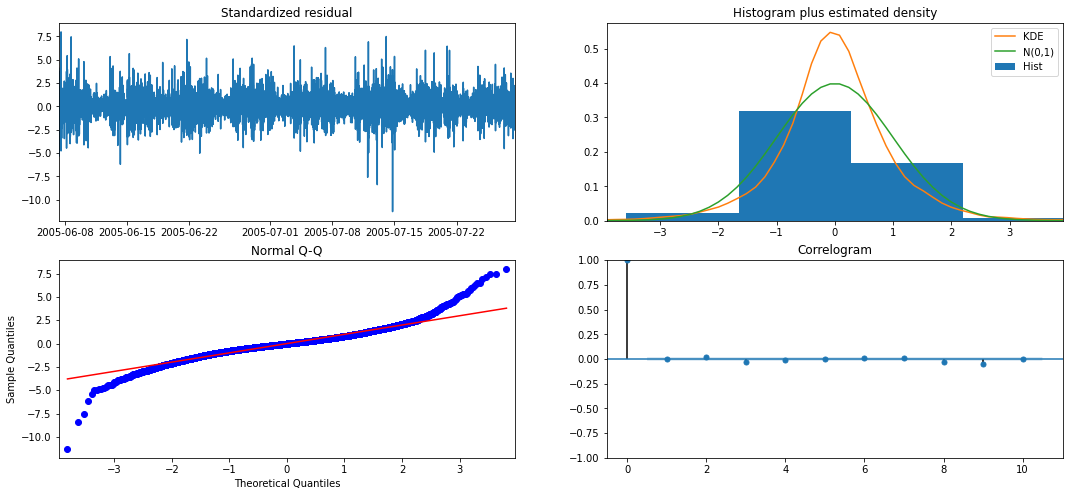

In [86]:
results.plot_diagnostics()
plt.show()

#### Predicción 5 min 

In [59]:
df_a5m.shape[0] * 0.80

11817.6

In [87]:
start = df_a5m.reset_index().iloc[11_818, 0]
end = df_a5m.reset_index().iloc[-1, 0]
start, end

(Timestamp('2005-07-18 07:47:00'), Timestamp('2005-07-28 13:52:00'))

In [88]:
pred = results.predict(start=start, end=end)
pred_ci = results.get_prediction(start=start, end=end).conf_int()

df_pred = pd.DataFrame(pred, index=df_a5m.iloc[11_818:].index, columns=['bits'])

In [89]:
df_pred.head()

,bits
date,
2005-07-18 07:47:00,5.700465e+10
2005-07-18 07:52:00,5.662951e+10
2005-07-18 07:57:00,5.357976e+10
2005-07-18 08:02:00,5.464601e+10
2005-07-18 08:07:00,5.293573e+10


In [90]:
pred_ci.head()

,lower bits,upper bits
2005-07-18 07:47:00,4.909088e+10,6.491841e+10
2005-07-18 07:52:00,4.871574e+10,6.454327e+10
2005-07-18 07:57:00,4.566599e+10,6.149352e+10
2005-07-18 08:02:00,4.673224e+10,6.255978e+10
2005-07-18 08:07:00,4.502196e+10,6.084950e+10


In [91]:
df_prediction = pd.concat([df_pred, pred_ci], axis=1)
df_prediction.head()

,bits,lower bits,upper bits
2005-07-18 07:47:00,5.700465e+10,4.909088e+10,6.491841e+10
2005-07-18 07:52:00,5.662951e+10,4.871574e+10,6.454327e+10
2005-07-18 07:57:00,5.357976e+10,4.566599e+10,6.149352e+10
2005-07-18 08:02:00,5.464601e+10,4.673224e+10,6.255978e+10
2005-07-18 08:07:00,5.293573e+10,4.502196e+10,6.084950e+10


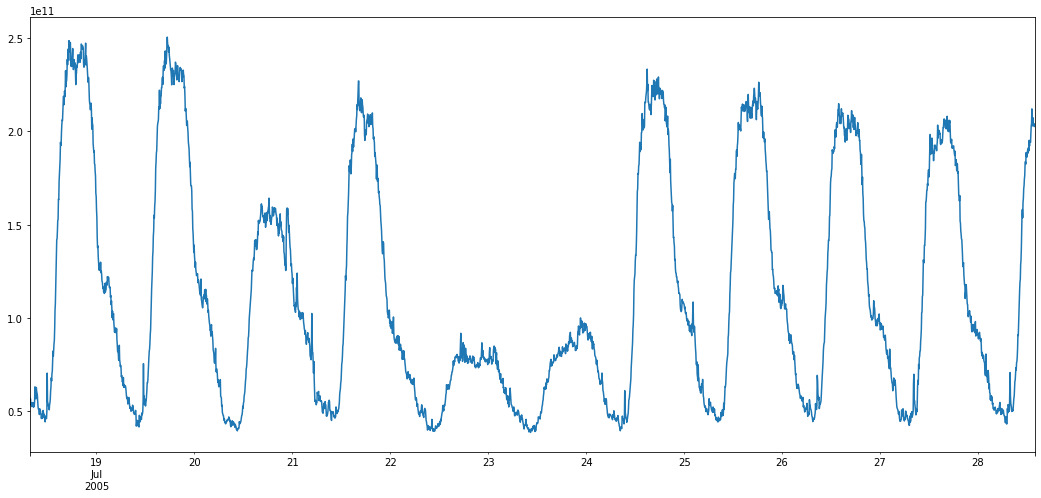

In [92]:
df_prediction['bits'].plot()

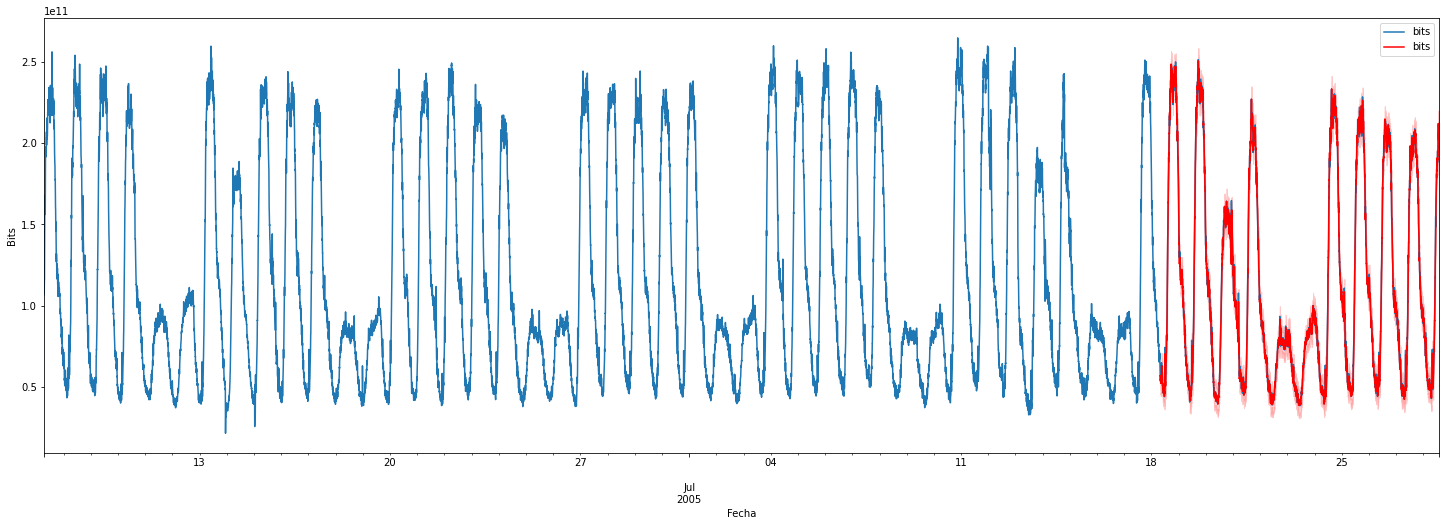

In [98]:
rcParams['figure.figsize'] = 25, 8
ax = df_a5m.plot(label='observed')
df_prediction['bits'].plot(c='r')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='r', alpha=.2)

ax.set_xlabel('Fecha')
ax.set_ylabel('Bits')
plt.legend()

plt.show()

#### Modelo 1 hora

In [105]:
# (0, 1, 2)x(2, 2, 2, 24)
model_a1h = SARIMAX(df_a1h,
                order=(0, 1, 2),
                seasonal_order=(2, 2, 2, 24),
                enforce_stationarity=False)

results = model_a1h.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                               bits   No. Observations:                 1231
Model:             SARIMAX(0, 1, 2)x(2, 2, 2, 24)   Log Likelihood              -30761.635
Date:                            Mon, 27 Sep 2021   AIC                          61537.270
Time:                                    14:00:37   BIC                          61572.486
Sample:                                06-07-2005   HQIC                         61550.574
                                     - 07-28-2005                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.5881      0.039     15.246      0.000       0.512       0.664
ma.L2          0.2096      0.055      3.780      0.000       0.101       0.318
ar.S.L24      -0.0332      0.181     -0.183      0.855      -0.388       0.322
ar.S.L48      -0.1484      0.077     -1.925      0.054      -0.300       0.003
ma.S.L24      -1.1581      0.171     -6.787      0.000      -1.493      -0.824
ma.S.L48       0.3014      0.160      1.887      0.059      -0.012       0.614
sigma2      4.447e+22        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (Q):                      354.64   Jarque-Bera (JB):              1801.90
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.26   Skew:                            -0.19
Prob(H) (two-sided):                  0.03   Kurtosis:                         9.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.86e+61. Standard errors may be unstable.
"""

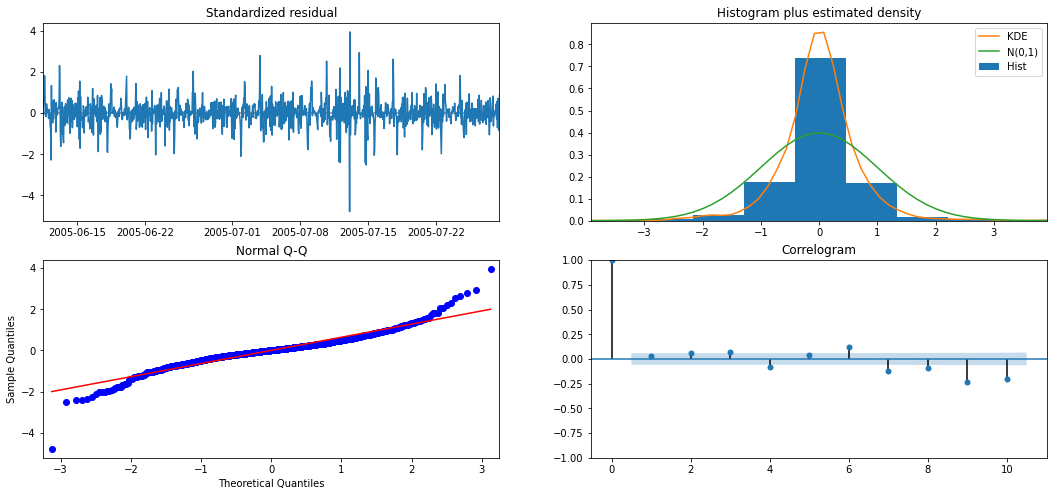

In [106]:
results.plot_diagnostics()
plt.show()

#### Predicción 1 hora

In [104]:
df_a1h.shape[0] * 0.80

984.8000000000001

In [107]:
start = df_a1h.reset_index().iloc[985, 0]
end = df_a1h.reset_index().iloc[-1, 0]
start, end

(Timestamp('2005-07-18 07:57:00'), Timestamp('2005-07-28 12:57:00'))

In [108]:
pred = results.get_prediction(start=start,
                              end=end)
pred_ci = pred.conf_int()

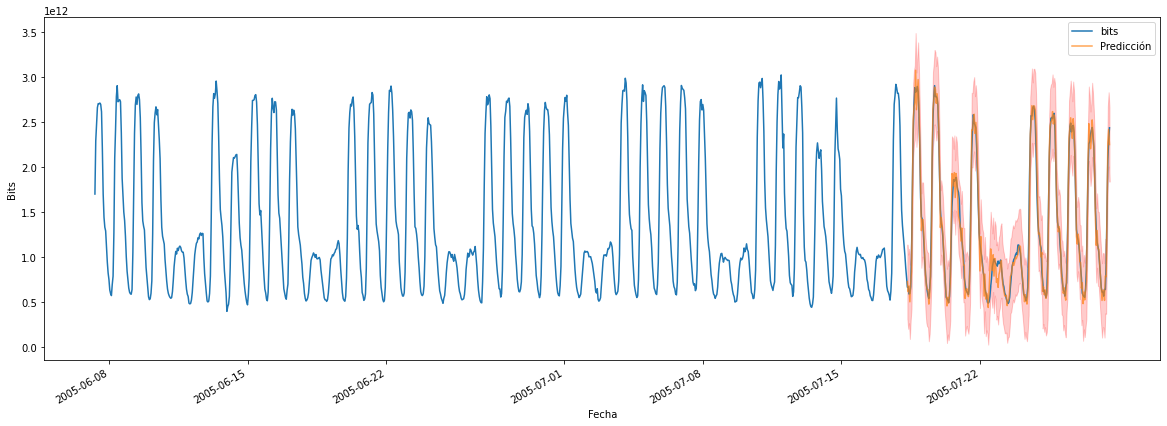

In [109]:
ax = df_a1h.plot(label='Oberservados')
pred.predicted_mean.plot(ax=ax, label='Predicción', alpha=.7, figsize=(20, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='r', alpha=.2)

ax.set_xlabel('Fecha')
ax.set_ylabel('Bits')
plt.legend()

plt.show()

#### Modelo 1 día

In [129]:
# ARIMA(0, 0, 0)x(2, 2, 0, 12) - AIC:0.6808653360986412
model_a1d = SARIMAX(df_a1d['difference_1'].dropna(),
                order=(2, 1, 0),
                seasonal_order=(0, 1, 0, 12),
                enforce_stationarity=False)

results = model_a1d.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                       difference_1   No. Observations:                   50
Model:             SARIMAX(2, 1, 0)x(0, 1, 0, 12)   Log Likelihood               -1110.043
Date:                            Mon, 27 Sep 2021   AIC                           2226.087
Time:                                    14:33:28   BIC                           2230.753
Sample:                                06-08-2005   HQIC                          2227.697
                                     - 07-27-2005                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4103      0.162     -2.540      0.011      -0.727      -0.094
ar.L2         -0.7238      0.132     -5.491      0.000      -0.982      -0.465
sigma2      2.067e+26   1.03e-28      2e+54      0.000    2.07e+26    2.07e+26
===================================================================================
Ljung-Box (Q):                         nan   Jarque-Bera (JB):                 6.82
Prob(Q):                               nan   Prob(JB):                         0.03
Heteroskedasticity (H):               1.09   Skew:                            -1.06
Prob(H) (two-sided):                  0.89   Kurtosis:                         3.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.42e+69. Standard errors may be unstable.
"""

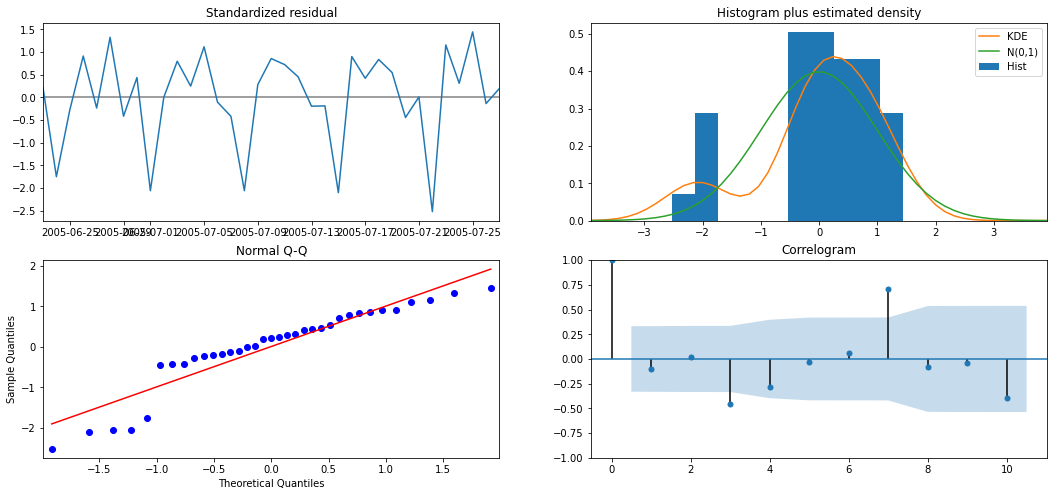

In [130]:
results.plot_diagnostics()
plt.show()

#### Predicción 1 día

In [131]:
df_a1d.shape[0] * 0.80

40.800000000000004

In [132]:
start = df_a1d.reset_index().iloc[40, 0]
end = df_a1d.reset_index().iloc[-1, 0]
start, end

(Timestamp('2005-07-17 00:00:00'), Timestamp('2005-07-27 00:00:00'))

In [133]:
pred = results.get_prediction(start=start,
                              end=end)
pred_ci = pred.conf_int()

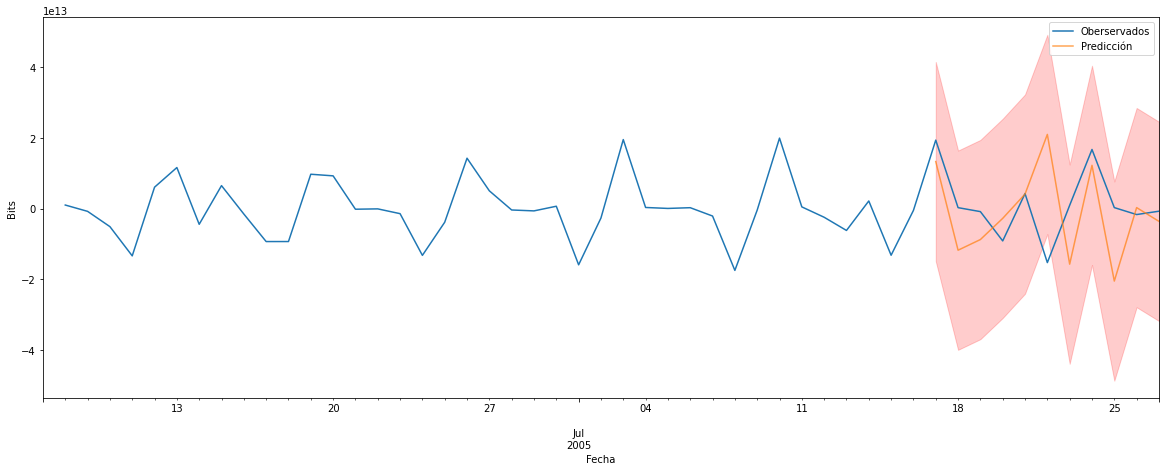

In [134]:
ax = df_a1d['difference_1'].plot(label='Oberservados')
pred.predicted_mean.plot(ax=ax, label='Predicción', alpha=.7, figsize=(20, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='r', alpha=.2)

ax.set_xlabel('Fecha')
ax.set_ylabel('Bits')
plt.legend()

plt.show()